In [1]:
import os
import glob
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys

from torch.utils.data import Dataset
from typing import Optional, Callable, List, Dict, Tuple, Any
from tqdm import tqdm
import json

In [2]:
sys.path.append("/media/ana-caznok/SSD-08/recon-segment/")
sys.path.append("/media/ana-caznok/SSD-08/recon-segment/transforms")

In [3]:
from transforms.factory import transform_factory

/home/ana-caznok/software/src/miniforge3/envs/agrvai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#27/11 
class FixedDataset(Dataset):  
    '''
    Simply read data and apply a transform. 
    '''  
    # TODO define 5 folds
    VAL_LIST: List[str] = ["p009", "p046", "p045", "p034", "p021"]  # fold 0
    def __init__(self, 
                 mode: str,
                 base_path: str,
                 transform: Optional[Callable] = None,  # real time processing
                 preprocessing: Optional[str] = None, # pre-processing
                 **kwargs):
        
        super().__init__()
  
        for k, v in kwargs:
            print(f"WARNING: Ignoring dataset argument {k}: {v}")

        self.mode = mode
        self.transform = transform
        self.base_path = base_path
        self.preprocessing = preprocessing
    
        if self.preprocessing == "None":
            print("WARNING: interpreting None string as None type")
            self.preprocessing = None
        
        if self.preprocessing is None:
            fmt = "*.mat"
        elif self.preprocessing == "downsampled":
            fmt = "*.npy"
        elif self.preprocessing == "h5py":
            print("Loading from hdf files")
            fmt = "*.hdf"
            self.h5file_path = os.path.join(self.base_path, f"{self.mode}.hdf")
            with h5py.File(self.h5file_path, 'r') as h5file:
                self.keys = list(h5file.keys())
            self.total_files = len(self.keys)

        self.fmt = fmt

        if mode != 'test':
            if self.preprocessing != "h5py":
                self.msi_files: List[str] = sorted(glob.glob(os.path.join(self.base_path, "Hyper-Skin(MSI, NIR)", "train", "MSI_CIE", fmt)))
                self.vis_files: List[str] = sorted(glob.glob(os.path.join(self.base_path, "Hyper-Skin(RGB, VIS)", "train", "VIS", fmt)))
                self.nir_files: List[str] = sorted(glob.glob(os.path.join(self.base_path, "Hyper-Skin(MSI, NIR)", "train", "NIR", fmt)))
            
                # Filter by fixed validation list and mode
                self.msi_files = self.filter_files(self.msi_files)[mode]
                self.vis_files = self.filter_files(self.vis_files)[mode]
                self.nir_files = self.filter_files(self.nir_files)[mode]

                self.total_files = len(self.msi_files)
                assert len(self.msi_files) == len(self.vis_files) == len(self.nir_files) == self.total_files, f"Length {self.total_files} is not matching among 3 folders"
            
            # Temporarily removed, buggy
            self.bb = []
            self.bb_names = []
            try:
                self.bb_names, self.bb = self.read_BB(mode, downsample = self.preprocessing == "downsampled")
            except FileNotFoundError as error:
                print(f"ERROR: Didn't found boundingbox files!: {error}")
                print("Continuinig without loading bounding boxes.")
            
            self.mask_files: List[str] = sorted(glob.glob(os.path.join(self.base_path, "masks_full_size_large-model", '*.npy')))
            self.mask_files = self.filter_files(self.mask_files)[mode]
            nmasks = len(self.mask_files)
            if nmasks != self.total_files:
                raise ValueError(f"Number of masks is not number of files...? {nmasks} / {self.total_files}")
            
            print(f"Number of face masks {len(self.mask_files)}.", end=" ")

        if mode == "test":
            fmt = '*.mat'
            self.msi_files: List[str] = sorted(glob.glob(os.path.join(self.base_path, "Hyper-Skin(MSI, NIR)", "test", '*.mat')))
            self.vis_files: List[str] = ['No_Target']*len(self.msi_files)
            self.nir_files: List[str] = ['No_Target']*len(self.msi_files)
            self.bb = ['No_BB']*len(self.msi_files)
            self.total_files = len(self.msi_files)

        print(self.init_str())

    def init_str(self):
        return f"initialized {self.total_files} images {self.mode} DatasetRaw with preprocessing: {self.preprocessing} in {self.base_path} with transform {self.transform}"

    def load_masks(self, idx: int): 
        m_file = self.mask_files[idx]
        
        mask_ID = os.path.basename(m_file).replace("-mask.npy", '')
        mask = np.load(m_file)

        # Workaround, downsamples face only in downsampled preprocessing or downsample of both input and target
        if self.preprocessing == 'downsampled': 
            mask = mask[::4,::4]

        return mask, mask_ID

    def filter_files(self, files: List[str]) -> Dict[str, List[str]]:
        val_files = []
        train_files = []
        for file in files:
            val = False
            for val_idx in FixedDataset.VAL_LIST:
                if val_idx in file:
                    val_files.append(file)
                    val = True
            
            if not val:
                train_files.append(file)
        
        return {"train": train_files, "val": val_files}

    def loadCube(self, cube_path: str) -> np.ndarray:
        '''
        return cube channel first.
        Original transpose: 2, 1, 0
        Channel first, but keep face orientation: 0, 2, 1
        intensity range: (0, 1)
        '''
        with h5py.File(cube_path, 'r') as f:
            array: np.ndarray = f['cube'][:].transpose(0, 2, 1)  # correct face orientation and channel first
            return array.squeeze()
            
    
    def loadPreprocessing(self, path: str) -> np.ndarray:
        return np.load(path)

    def loadData(self, msi_path: str, vis_path: str, nir_path: str) -> Tuple[np.ndarray, np.ndarray]:
        '''
        Convenção: remove first channel from NIR for 61 total channels (31 + (31 - 1))
        '''
        if self.preprocessing is None:
            msi_input = self.loadCube(msi_path)
            if self.mode != "test":
                target = np.concatenate([self.loadCube(vis_path), self.loadCube(nir_path)[1:]], axis=0) #new, output 61
            else:
                target = "None"
        elif self.preprocessing == "downsampled":
            msi_input = self.loadPreprocessing(msi_path)
            target = np.concatenate([self.loadPreprocessing(vis_path), self.loadPreprocessing(nir_path)[1:]], axis=0) #new, output 61

        return msi_input, target 
    
    def read_BB(self, r_mode: str, downsample: bool = True) -> Tuple[List[str], List[List[int]]]: 
        face_path = os.path.join(self.base_path, "bounding-boxes/")
        file_name = 'faces_bb_NIR_w-rgb_BEST.json'
      
        mode_dict = {'train': True, 
                     'val': False}

        with open(face_path + file_name) as json_file:
            faceseg_BB = json.load(json_file)

        key_array = np.asarray([k  for  k in  faceseg_BB.keys()])
        values_array = np.asarray([np.asarray(v)  for  v in  faceseg_BB.values()])

        name_list = []
        for k in key_array: 
            name_list.append(k.split('_')[0])
        
        mask = np.isin(name_list, np.asarray(FixedDataset.VAL_LIST), invert=mode_dict[r_mode])

        key_array = key_array[mask]
        values_array = values_array[mask]
        
        if downsample == True: 
            values_array = values_array//4

        return key_array, values_array

    def load_h5(self, idx: int) -> Tuple[np.ndarray, np.ndarray, str]: #TODO ainda falta arrumar output 61 para leitura h5, ainda não entendi como foi feito
        ID = self.keys[idx]
        with h5py.File(self.h5file_path, 'r') as h5file:
            # 31 canais, index 0 30
            vis = h5file[ID][4:4 + 31] # indices 4 ate 34 incluidos
            nir = h5file[ID][4 + 31 + 1:]  # skip first channel from nir, indices 36 ate o fim incluidos
            msi_input = h5file[ID][:4]  # indices 0 a 3
            target = np.concatenate((vis, nir), axis=0)

        return msi_input, target, ID

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, Any]]:
        # Read preprocessed or raw
        if self.preprocessing == "h5py":
            msi_input, target, ID = self.load_h5(idx)
        else:
            msi_input, target = self.loadData(self.msi_files[idx], self.vis_files[idx], self.nir_files[idx])
            ID = os.path.basename(self.msi_files[idx]).replace(self.fmt[1:], '')
        
        try:
            mask_input, mask_ID = self.load_masks(idx)
            mask_input = np.expand_dims(mask_input, 0) 
        except: 
            mask_input = "None"
            mask_ID = None

        if mask_ID is not None:
            assert mask_ID == ID, f"Mask is not the same as person: {mask_ID} / {ID}"

        try:
            img_bb = self.bb[idx]
        except IndexError:
            img_bb = "None"
        
        metadata = {"ID": ID, "bbox": img_bb, "mask": mask_input}

        if self.transform is not None:
            msi_input, target, metadata = self.transform(msi_input, target, metadata)

        # Torch conversion is not in transforms from transform_factory
        msi_input = torch.from_numpy(msi_input).float()
        
        # Target might be "None" in test
        if not isinstance(target, str):
            target = torch.from_numpy(target).float()

        if mask_ID is not None:
            metadata["mask"] = torch.from_numpy(metadata["mask"]).float()

        return msi_input, target, metadata

    def __len__(self):
        return self.total_files

In [ ]:
# base_path_ana = os.getenv("ICASP_DOWNSAMPLED")
#base_path_ana= '/mnt/datassd/icasp/data/preprocessed/downsampled'
#preprocessing = "downsampled"

#base_path_ana= '/mnt/datassd/icasp/data/raw/Link_2/'
#preprocessing = None

base_path_ana=  os.getenv('ICASP_H5')
preprocessing = 'h5py'

In [ ]:
os.getenv("ICASP_DOWNSAMPLED")

#### Check repeated image

In [5]:
my_transform = transform_factory('fft_D40_x_gpu')

In [6]:
dataset = FixedDataset("train", '/media/ana-caznok/SSD-08/icasp_4090/icasp/data/Link_2', preprocessing='h5py', transform=my_transform)

Loading from hdf files
Number of face masks 234. initialized 234 images train DatasetRaw with preprocessing: h5py in /media/ana-caznok/SSD-08/icasp_4090/icasp/data/Link_2 with transform 
0: RGB2Pseudo_Hyp with: /media/ana-caznok/SSD-08/recon-segment/ and camera D40
1: FourierSpectralTransform(norm=minmax, transform cube=False, device=cuda)


In [ ]:
os.getenv("ICASP_H5")

In [ ]:
dataset.keys[0]

In [7]:
x, y, m = dataset[0]

In [ ]:

diffs = [torch.abs((y[i] - y[i+1]).sum()).item() for i in range(y.shape[0] - 1)]

In [ ]:
plt.plot(diffs, '*')

In [ ]:
np.array(diffs).min()

In [ ]:
from fixed_dataset import FixedDataset as NewFixedDataset
dataset_new = NewFixedDataset("train", os.getenv("ICASP"))

In [ ]:
x, y, m = dataset_new[0]

In [ ]:

new_diffs = [torch.abs((y[i] - y[i+1]).sum()).item() for i in range(y.shape[0] - 1)]


In [ ]:
plt.subplot(1, 2, 1)
plt.plot(diffs, '*')
plt.subplot(1, 2, 2)
plt.plot(new_diffs, '*')
plt.figure()
plt.plot(np.array(diffs[:-1]) - np.array(new_diffs))
plt.show()


In [ ]:
np.array(new_diffs).min(), np.array(new_diffs).argmin()

In [ ]:
from fixed_dataset import FixedDataset as NewFixedDataset
dataset_new_h5 = NewFixedDataset("train", os.getenv("ICASP"), preprocessing="h5py")

In [ ]:
dataset_new_h5.h5file_path

In [ ]:
x, y, m = dataset_new_h5[0]

In [ ]:
x.shape, y.shape

In [ ]:
from fixed_dataset import FixedDataseabst as NewFixedDataset
dataset_new_h5 = NewFixedDataset("train", os.getenv("ICASP"), preprocessing="h5py")
raw_dataset = NewFixedDataset("train", os.getenv("ICASP"), preprocessing=None)
x, y, m = dataset_new_h5[0]
rx, ry, rm = raw_dataset[0]
print(f"raw: {ry.shape}, h5: {y.shape}")
h5_diffs = [torch.abs((y[i] - y[i+1]).sum()).item() for i in range(60)]
raw_diffs = [torch.abs((ry[i] - ry[i+1]).sum()).item() for i in range(60)]
plt.plot(h5_diffs, label="H5")
plt.plot(raw_diffs, label="Raw")
plt.plot(np.array(h5_diffs) - np.array(raw_diffs), label="Subtract")
plt.legend()

#### Testing transforms 

In [ ]:
my_transform = transform_factory('hist_match_h5_04_and_patch_512')
str(my_transform)

In [ ]:
dataset = FixedDataset(mode = 'train', base_path=base_path_ana, preprocessing=preprocessing, transform = my_transform)

In [ ]:
dataset.total_files

In [ ]:
x_np.shape

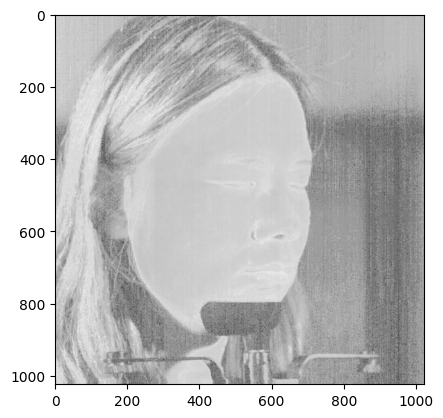

In [14]:
import random

x, y, m = random.choice(dataset)
x_np = x.numpy()

plt.imshow(x_np[30],cmap='gray')
plt.show()

In [15]:
x_np.max()

1.0

In [16]:
x_np.min()

5.9604645e-08

In [ ]:
from torchvision.utils import make_grid

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=16)

In [ ]:
dataloader_debug = iter(dataloader)

In [ ]:
x, y, m = next(dataloader_debug)

plt.imshow(make_grid(x[:, :3]).permute(1, 2, 0))


In [ ]:
for batch in tqdm(dataloader):
    pass

In [ ]:
path = '/mnt/datassd/icasp/RainbowAI/models_h5/mst_face_test_output/'

In [ ]:
test_array = np.load(sorted(glob.glob(path+'*.npy'))[0])

In [ ]:
test_array.shape